#**Support Vector Machine - Classification (Scratch)**

###**Kernels in SVM:**
- **Linear:** For linearly separable data.
- **Polynomial:** For polynomial relationships in data.
- **RBF (Gaussian):** For highly non-linear data, most popular in real-world applications.
- **Sigmoid:** Similar to neural network activations, used for non-linear relationships.
- **Custom:** For special use cases with specific domain knowledge.

###**Loss Functions of SVM:**
- **Hinge Loss and Squared Hinge Loss** are widely used for their effectiveness in creating a large margin.
- **Logistic Loss** provides a probabilistic interpretation and smoother optimization.
- **Zero-One Loss** is less practical due to optimization challenges.
- **Soft Margin Loss** is practical for handling real-world data where perfect separation may not be possible.

**Import Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from collections import Counter
from sklearn.datasets import load_diabetes, load_iris, fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import precision_score, recall_score, f1_score, explained_variance_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

**Code**

In [2]:
class SVM:
    def __init__(self, kernel='linear', C=1.0, loss='hinge', degree=3, gamma='scale', n_epochs=10, learning_rate=0.01):
        self.kernel = kernel
        self.C = C
        self.loss_function = loss
        self.degree = degree
        self.gamma = gamma
        self.n_epochs = n_epochs
        self.learning_rate = learning_rate
        self.models = []
        self.class_labels = None
        self.X_train = None

    def _kernel(self, X1, X2):
        n_samples_1, n_features_1 = X1.shape
        n_samples_2, n_features_2 = X2.shape

        if self.kernel == 'linear':
            return np.dot(X1, X2.T)
        elif self.kernel == 'polynomial':
            return (np.dot(X1, X2.T) + 1) ** self.degree
        elif self.kernel == 'rbf':
            # Determine gamma based on its current value
            if isinstance(self.gamma, str):
                if self.gamma == 'scale':
                    self.gamma = 1 / n_features_1  # Scale based on number of features
                elif self.gamma == 'auto':
                    self.gamma = 1 / n_samples_1  # Auto based on number of samples

            # Proceed with RBF kernel calculation
            diff = X1[:, np.newaxis, :] - X2[np.newaxis, :, :]
            return np.exp(-self.gamma * np.sum(diff ** 2, axis=2))
        elif self.kernel == 'sigmoid':
            return np.tanh(np.dot(X1, X2.T))  # Example of adding a sigmoid kernel
        else:
            raise ValueError("Unknown kernel type. Add the kernel function as needed.")

    def _hinge_loss(self, linear_output, y):
        return np.maximum(0, 1 - y * linear_output)

    def _squared_hinge_loss(self, linear_output, y):
        return np.square(np.maximum(0, 1 - y * linear_output))

    def _logistic_loss(self, linear_output, y):
        return np.log(1 + np.exp(-y * linear_output))

    def fit(self, X, y):
        self.class_labels = np.unique(y)
        self.X_train = X
        self.y_train = y  # Store training labels
        total_losses = np.zeros((self.n_epochs, len(self.class_labels)))
        self.models = []

        # Compute kernel matrix for all training data once
        K_full = self._kernel(X, X)

        for class_id, class_label in enumerate(self.class_labels):
            binary_y = np.where(y == class_label, 1, -1)
            alpha = np.zeros(X.shape[0])
            b = 0

            for epoch in range(self.n_epochs):
                epoch_loss = 0

                linear_output = np.sum(alpha * binary_y[:, np.newaxis] * K_full, axis=0) - b

                # Select the appropriate loss function
                if self.loss_function == 'hinge':
                    loss = self._hinge_loss(linear_output, binary_y)
                elif self.loss_function == 'squared_hinge':
                    loss = self._squared_hinge_loss(linear_output, binary_y)
                elif self.loss_function == 'logistic':
                    loss = self._logistic_loss(linear_output, binary_y)
                else:
                    raise ValueError("Unknown loss function.")

                epoch_loss = np.mean(loss)  # Averaging the loss per sample

                # Update alpha and b where there is a margin violation
                mask = loss > 0
                alpha[mask] += self.learning_rate * self.C * binary_y[mask]
                b -= self.learning_rate * self.C * np.sum(binary_y[mask])

                total_losses[epoch, class_id] = epoch_loss

            self.models.append((alpha, b))

        self.loss_history = total_losses

        # Print average loss for each epoch
        for epoch in range(self.n_epochs):
            average_loss = np.mean(total_losses[epoch])
            print(f"Epoch {epoch + 1}/{self.n_epochs}, Average {self.loss_function.capitalize()} Loss: {average_loss:.2f}")

        # Calculate and print total loss
        total_loss = np.sum(total_losses)
        print(f"Total Loss after {self.n_epochs} epochs: {total_loss:.2f}")

    def predict(self, X):
        class_scores = np.zeros((X.shape[0], len(self.class_labels)))
        K_test = self._kernel(X, self.X_train)  # Compute kernel once for test data

        for i, (alpha, b) in enumerate(self.models):
            class_scores[:, i] = np.sum(alpha * K_test * (np.where(self.y_train == self.class_labels[i], 1, -1)), axis=1) - b

        return np.argmax(class_scores, axis=1)

**Load Dataset**

In [3]:
# Load Iris dataset
iris = load_iris()
X = iris.data[:, :2]  # Use only the first two features for visualization
y = iris.target

In [4]:
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((105, 2), (45, 2), (105,), (45,))

In [5]:
# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [6]:
# Train
svm_model = SVM(kernel='rbf', C=1.0, loss='hinge', degree=3, gamma='scale', n_epochs=10, learning_rate=0.01)
svm_model.fit(X_train, y_train)

Epoch 1/10, Average Hinge Loss: 1.00
Epoch 2/10, Average Hinge Loss: 1.00
Epoch 3/10, Average Hinge Loss: 0.99
Epoch 4/10, Average Hinge Loss: 0.99
Epoch 5/10, Average Hinge Loss: 1.02
Epoch 6/10, Average Hinge Loss: 1.08
Epoch 7/10, Average Hinge Loss: 1.15
Epoch 8/10, Average Hinge Loss: 1.22
Epoch 9/10, Average Hinge Loss: 1.30
Epoch 10/10, Average Hinge Loss: 1.37
Total Loss after 10 epochs: 33.37


In [7]:
# Make predictions
y_pred = svm_model.predict(X_test)
print(y_pred)

[1 1 1 1 1 1 2 1 1 2 1 1 1 1 1 1 1 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 2 1 1 1 1]


In [8]:
# Evaluate model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print(f"Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.22
Precision: 0.12
Recall: 0.22
F1 Score: 0.13
Confusion Matrix:
 [[ 0 19  0]
 [ 0  9  4]
 [ 0 12  1]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        19
           1       0.23      0.69      0.34        13
           2       0.20      0.08      0.11        13

    accuracy                           0.22        45
   macro avg       0.14      0.26      0.15        45
weighted avg       0.12      0.22      0.13        45



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

**Visualization**

In [9]:
# Visualization function
def plot_decision_boundary(X, y, model, title):
    # Create a mesh grid for visualization
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(10, 6))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o', s=100, label='Data Points')
    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.grid(True)
    plt.show()

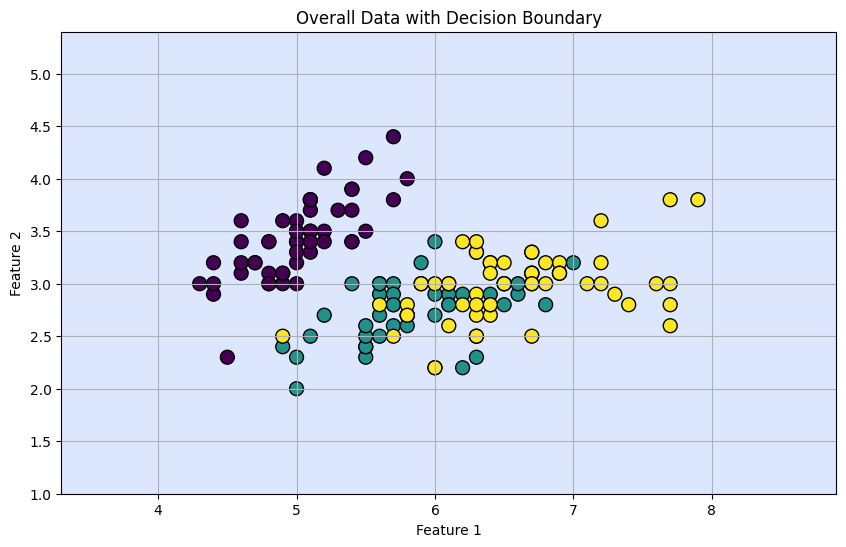

In [10]:
# Visualize Overall Data
plot_decision_boundary(X, y, svm_model, title='Overall Data with Decision Boundary')

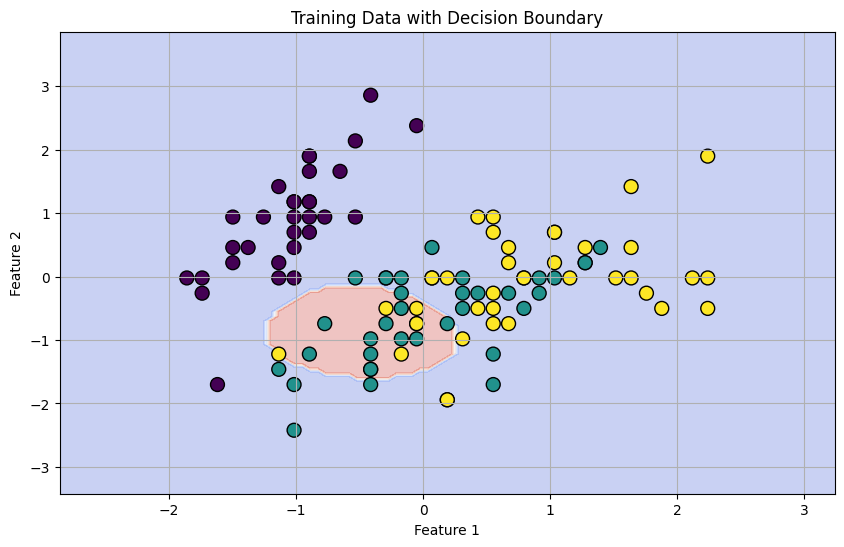

In [11]:
# Visualize Training Data
plot_decision_boundary(X_train, y_train, svm_model, title='Training Data with Decision Boundary')

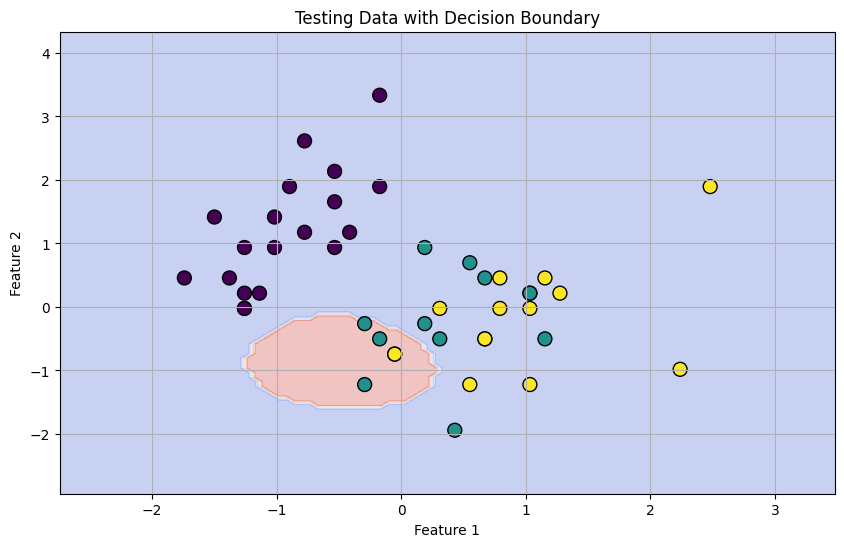

In [12]:
# Visualize Testing Data
plot_decision_boundary(X_test, y_test, svm_model, title='Testing Data with Decision Boundary')